# Lab 1: ConceptNet Ethics Testing

#### Henry Lambson, Alex Gregory, Mike Wisniewski

TODOs:
    - Choose a second methodology at assessing bias
        -Ideas: Instead of SGD for sentiment analysis we can use a LSTM
        -Change the dataset to another dataset

### Part 1: Overview of Bias

>Present an overview for what type of bias you will be investigating and why the particular investigation you will be doing is relevant. You might consider asking questions like: Why is it important to find this kind of bias in machine learning models? Why will the type of investigation I am performing be relevant to other researchers or practitioners? 


For our analysis of ConceptNet, our group decided to look into the potential bias the modal has to gender. We want to find out if there is a systematic difference between words associated with males and words associated with females. An example of this being "waiter" vs "waitress". We believe that this investigation is relevant because we think that ConceptNet trained on the large, unfiltered GloVe data will be inherently biased towards male positions. We believe that the model will be biased towards male terms in general, and we want to use job titles as a way to expose this bias. If the model is distriminatory when it is not meant to be, it can affect the business using the model, as well as the the consumers who use the business. From the business perspective, businesses risk their bottom line and credibility. From a consumer perspective, consumers are at risk of being alienated due to their identity. Due to this bias, we believe that low level NPL models can be biased in a way that will hurt businesses trying to reach consumers equally.    

### Part 2: Research Questions

>Present one or more research questions that you will be answering and explain the methods that you will employ to answer these research questions. Present a hypothesis as part of your research questions. 



Our main research question for this project is: "Is ConceptNet trained on the large GloVe data biased towards male job titles and biased against female job titles?" 

### Part 3: Methodology
>As part of your assignment, you will choose a methodology that involves comparing two (or more) techniques to one another. Discuss how you will measure a difference between the two techniques. That is, if you are measuring the difference statistically, what test will you use and why is it appropriate? Are there any limitations to performing this test that you should be aware of? 

### Preprocessing

This first large section of code is grabbed from the in class example. We are using the same pre-processing that was shown and used in class. Once we have a sentiment analyzer, we will begin testing it for different biases. 

In [25]:
# import relevant packages
import numpy as np
import pandas as pd
import matplotlib
import seaborn
import re
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# Configure how graphs will show up in this notebook
%matplotlib inline
seaborn.set_context('notebook', rc={'figure.figsize': (10, 6)}, font_scale=1.5)

In [26]:
%%time

# load embeddings from a given file name
def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

# load embeddings
embeddings = load_embeddings('glove.840B.300d/glove.840B.300d.txt')
embeddings.shape

UsageError: Line magic function `%%time` not found.


In [27]:
# load lexicons from a given file name
def load_lexicon(filename):
    """
    Load a file from Bing Liu's sentiment lexicon
    (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), containing
    English words in Latin-1 encoding.
    
    One file contains a list of positive words, and the other contains
    a list of negative words. The files contain comment lines starting
    with ';' and blank lines, which should be skipped.
    """
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

# import positive and negative words
pos_words = load_lexicon('opinion-lexicon-English/positive-words.txt')
neg_words = load_lexicon('opinion-lexicon-English/negative-words.txt')

In [29]:
# parse out the positive words that appear in our embeddings
pos_words_common = list(set(pos_words) & set(embeddings.index))

# parse out the negative words that appear in our embeddings
neg_words_common = list(set(neg_words) & set(embeddings.index)) 

# vectorize positive and negative common words
pos_vectors = embeddings.loc[pos_words_common]
neg_vectors = embeddings.loc[neg_words_common]

# create pd dataframe of positive and negative vectors
vectors = pd.concat([pos_vectors, neg_vectors])

In [9]:
# create a numerical representation of positive and negative vectors
targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
labels = list(pos_vectors.index) + list(neg_vectors.index)

In [10]:
# split the dataset
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

In [18]:
# initialize log loss classifier
model = SGDClassifier(loss='log_loss', random_state=0, max_iter=100)

# fit model
model.fit(train_vectors, train_targets)

# score model on test data
accuracy_score(model.predict(test_vectors), test_targets)

0.945619335347432

In [36]:
def vecs_to_sentiment(vecs):
    """
    To see an overall positive vs. negative classification in one number,
    we take the log probability of positive sentiment minus the log
    probability of negative sentiment.
    this is a logarithm of the max margin for the classifier, 
    similar to odds ratio (but not exact) log(p_1/p_0) = log(p_1)-log(p_0)
    """

    # predict_log_proba gives the log probability for each class
    predictions = model.predict_log_proba(vecs)

    return predictions[:, 1] - predictions[:, 0]


def words_to_sentiment(words):
    # vectorize the word
    vecs = embeddings.loc[words].dropna()

    # calculate log probability
    log_odds = vecs_to_sentiment(vecs)
    return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)

# Show 20 examples from the test set
words_to_sentiment(test_labels).iloc[:20]

,sentiment
capricious,-11.120600
authoritative,9.482031
abrupt,-11.834456
left-leaning,0.532946
perfect,10.670480
encourage,9.548579
prodigious,0.824441
obsessiveness,-6.540577
frazzled,-8.681968
rail,-1.605864


In [20]:
TOKEN_RE = re.compile(r"\w.*?\b")
# The regex above finds tokens that start with a word-like character (\w), and continues
# matching characters (.+?) until the next word break (\b). It's a relatively simple
# expression that manages to extract something very much like words from text.

# sentiment for multiple words
def text_to_sentiment(text):

    # tokenize the input phrase
    tokens = [token.casefold() for token in TOKEN_RE.findall(text)]

    # send each token separately into the embedding, then the classifier
    sentiments = words_to_sentiment(tokens)

    # return the mean for the classifier
    return sentiments['sentiment'].mean() 

### Part 4: Analysis
> Carryout your analysis and model training. Explain your steps in as much detail so that the instructor can understand your code. 



From here, we will be testing out multiple datasets to try to find a bias due to gender. ConceptNet has a list of pairings that are typically associated with males and females. We decided to use this list as one of our datasets to test on. The female terms are on the left, and the male terms are on the right.

In [21]:
GENDER_BIAS_PAIRS = [
    ('pediatrician', 'orthopedic surgeon'),
    ('housewife', 'shopkeeper'),
    ('skirts', 'shorts'),
    ('interior designer', 'architect'),
    ('feminism', 'conservatism'),
    ('adorable', 'goofy'),
    ('vocalists', 'guitarists'),
    ('cosmetics', 'pharmaceuticals'),
    ('whore', 'coward'),
    ('vocalist', 'guitarist'),
    ('petite', 'lanky'),
    ('blond', 'burly'),
    ('nanny', 'chauffeur'),
    ('sassy', 'snappy'),
    ('charming', 'affable'),
    ('giggle', 'chuckle'),
    ('witch', 'demon'),
    ('volleyball', 'football'),
    ('feisty', 'mild mannered'),
    ('cupcakes', 'pizzas'),
    ('dolls', 'replicas'),
    ('netball', 'rugby'),
    ('glamorous', 'flashy'),
    ('sweater', 'jersey'),
    ('feminist', 'liberal'),
    ('rebounder', 'playmaker'),
    ('nude', 'shirtless'),
    ('judgmental', 'arrogant'),
    ('lovely', 'brilliant'),
    ('practicality', 'durability'),
    ('singer', 'frontman'),
    ('violinist', 'virtuoso'),
    ('beautiful', 'majestic'),
    ('sexism', 'racism'),
    ('pink', 'red'),
    ('hysterical', 'comical'),
    ('beauty', 'grandeur'),
    ('cheerful', 'jovial')
]

FEMALE_ARR = [x[0] for x in GENDER_BIAS_PAIRS]
MALE_ARR = [x[1] for x in GENDER_BIAS_PAIRS]
TERM_DICT = {"Female":FEMALE_ARR, "Male":MALE_ARR}

In [62]:
# create a table of sentiment values for each word
def term_sentiment_table():

    # initialize empty frame
    frames = []

    # for gender and term
    for gender, term_list in sorted(TERM_DICT.items()):
        for term in term_list:

            # calculate sentiment
            sentiments = text_to_sentiment(term)

            # append to dataframe
            frames.append([sentiments,term,gender])

    # Put together the data we got from each ethnic group into one big table
    return frames

# create a dataframe of sentiment values
term_sentiments = term_sentiment_table()
term_df = pd.DataFrame(term_sentiments, columns = ["Sentiment","Term","Gender"])

>Present results from your analysis and provide evidence from the results that support or refute your hypothesis. Write a conclusion based upon the various analyses you performed. Be sure to reference your research questions systematically in your conclusion. With your analysis complete, are there any additional research questions or limitations to your conclusions?

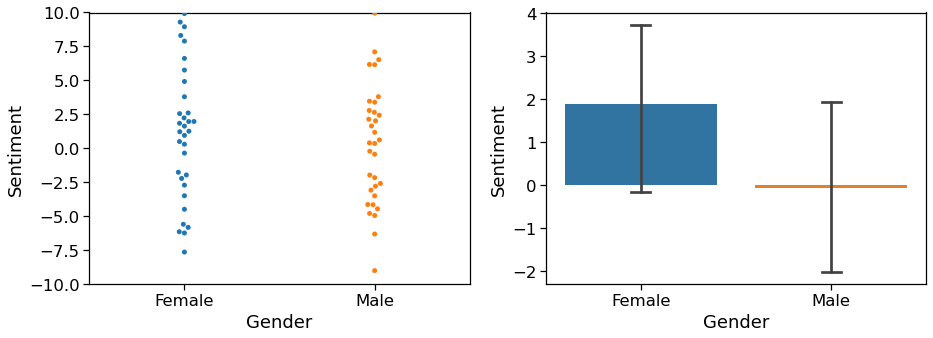

In [61]:
# analysis 1 with SGD
matplotlib.pyplot.figure(figsize=(15,5))
matplotlib.pyplot.subplot(121)
plot = seaborn.swarmplot(x='Gender', y='Sentiment', data=term_df)
plot.set_ylim([-10, 10]) 
matplotlib.pyplot.subplot(122)
plot = seaborn.barplot(x='Gender', y='Sentiment', data=term_df, capsize=.1)

In [ ]:
# analysis 2 with LSTM
matplotlib.pyplot.figure(figsize=(15,5))
matplotlib.pyplot.subplot(121)
plot = seaborn.swarmplot(x='Gender', y='Sentiment', data=term_df)
plot.set_ylim([-10, 10]) 
matplotlib.pyplot.subplot(122)
plot = seaborn.barplot(x='Gender', y='Sentiment', data=term_df, capsize=.1)

>Identify two conferences or journals that would be interested in the results of your analysis.  

### References
[1] https://careersmart.org.uk/occupations/equality/which-jobs-do-men-and-women-do-occupational-breakdown-gender